# Модульный контроль №1
### Михайловской Валерии

In [1]:
import pandas as pd
import json
import numpy as np
from matplotlib import pyplot as plt

### 1. Объедините информацию о пользователях в одной датафрейм

In [2]:
df_metrics_de = pd.read_csv('metrics_de.csv')

df_metrics_ru = pd.read_csv('metrics_ru.csv')
onboarding = pd.read_csv('onboarding.csv')

metrics = pd.concat([df_metrics_de, df_metrics_ru], ignore_index=True, sort=False)

metrics = metrics.fillna(0)

data = onboarding.merge(metrics, on='AccountID', how='inner')
data.to_csv('all_data.csv')

data = data.drop('Unnamed: 0_x', axis=1)
data = data.drop('Unnamed: 0_y', axis=1)


### 2. Информация о каком количестве пользователей представлена в данных? Какое количество видов деятельности? Постройте барплот по суммарному количеству пользователей по видам деятельности

In [3]:
onboarding_count = onboarding['AccountID'].nunique()
print('Количество пользователей в данных по онбордингу: ' + str(onboarding_count))

metrics_count = df_metrics_de['AccountID'].nunique() + df_metrics_ru['AccountID'].nunique()
print('Количество пользователей в данных метриках: ' + str(metrics_count))


Количество пользователей в данных по онбордингу: 8570
Количество пользователей в данных метриках: 9805


In [4]:
count_of_occupation = data.dropna(subset=['AccountOccupationText'])['AccountOccupationText'].nunique()
print("Количество видов детельности: " + str(count_of_occupation))

Количество видов детельности: 104


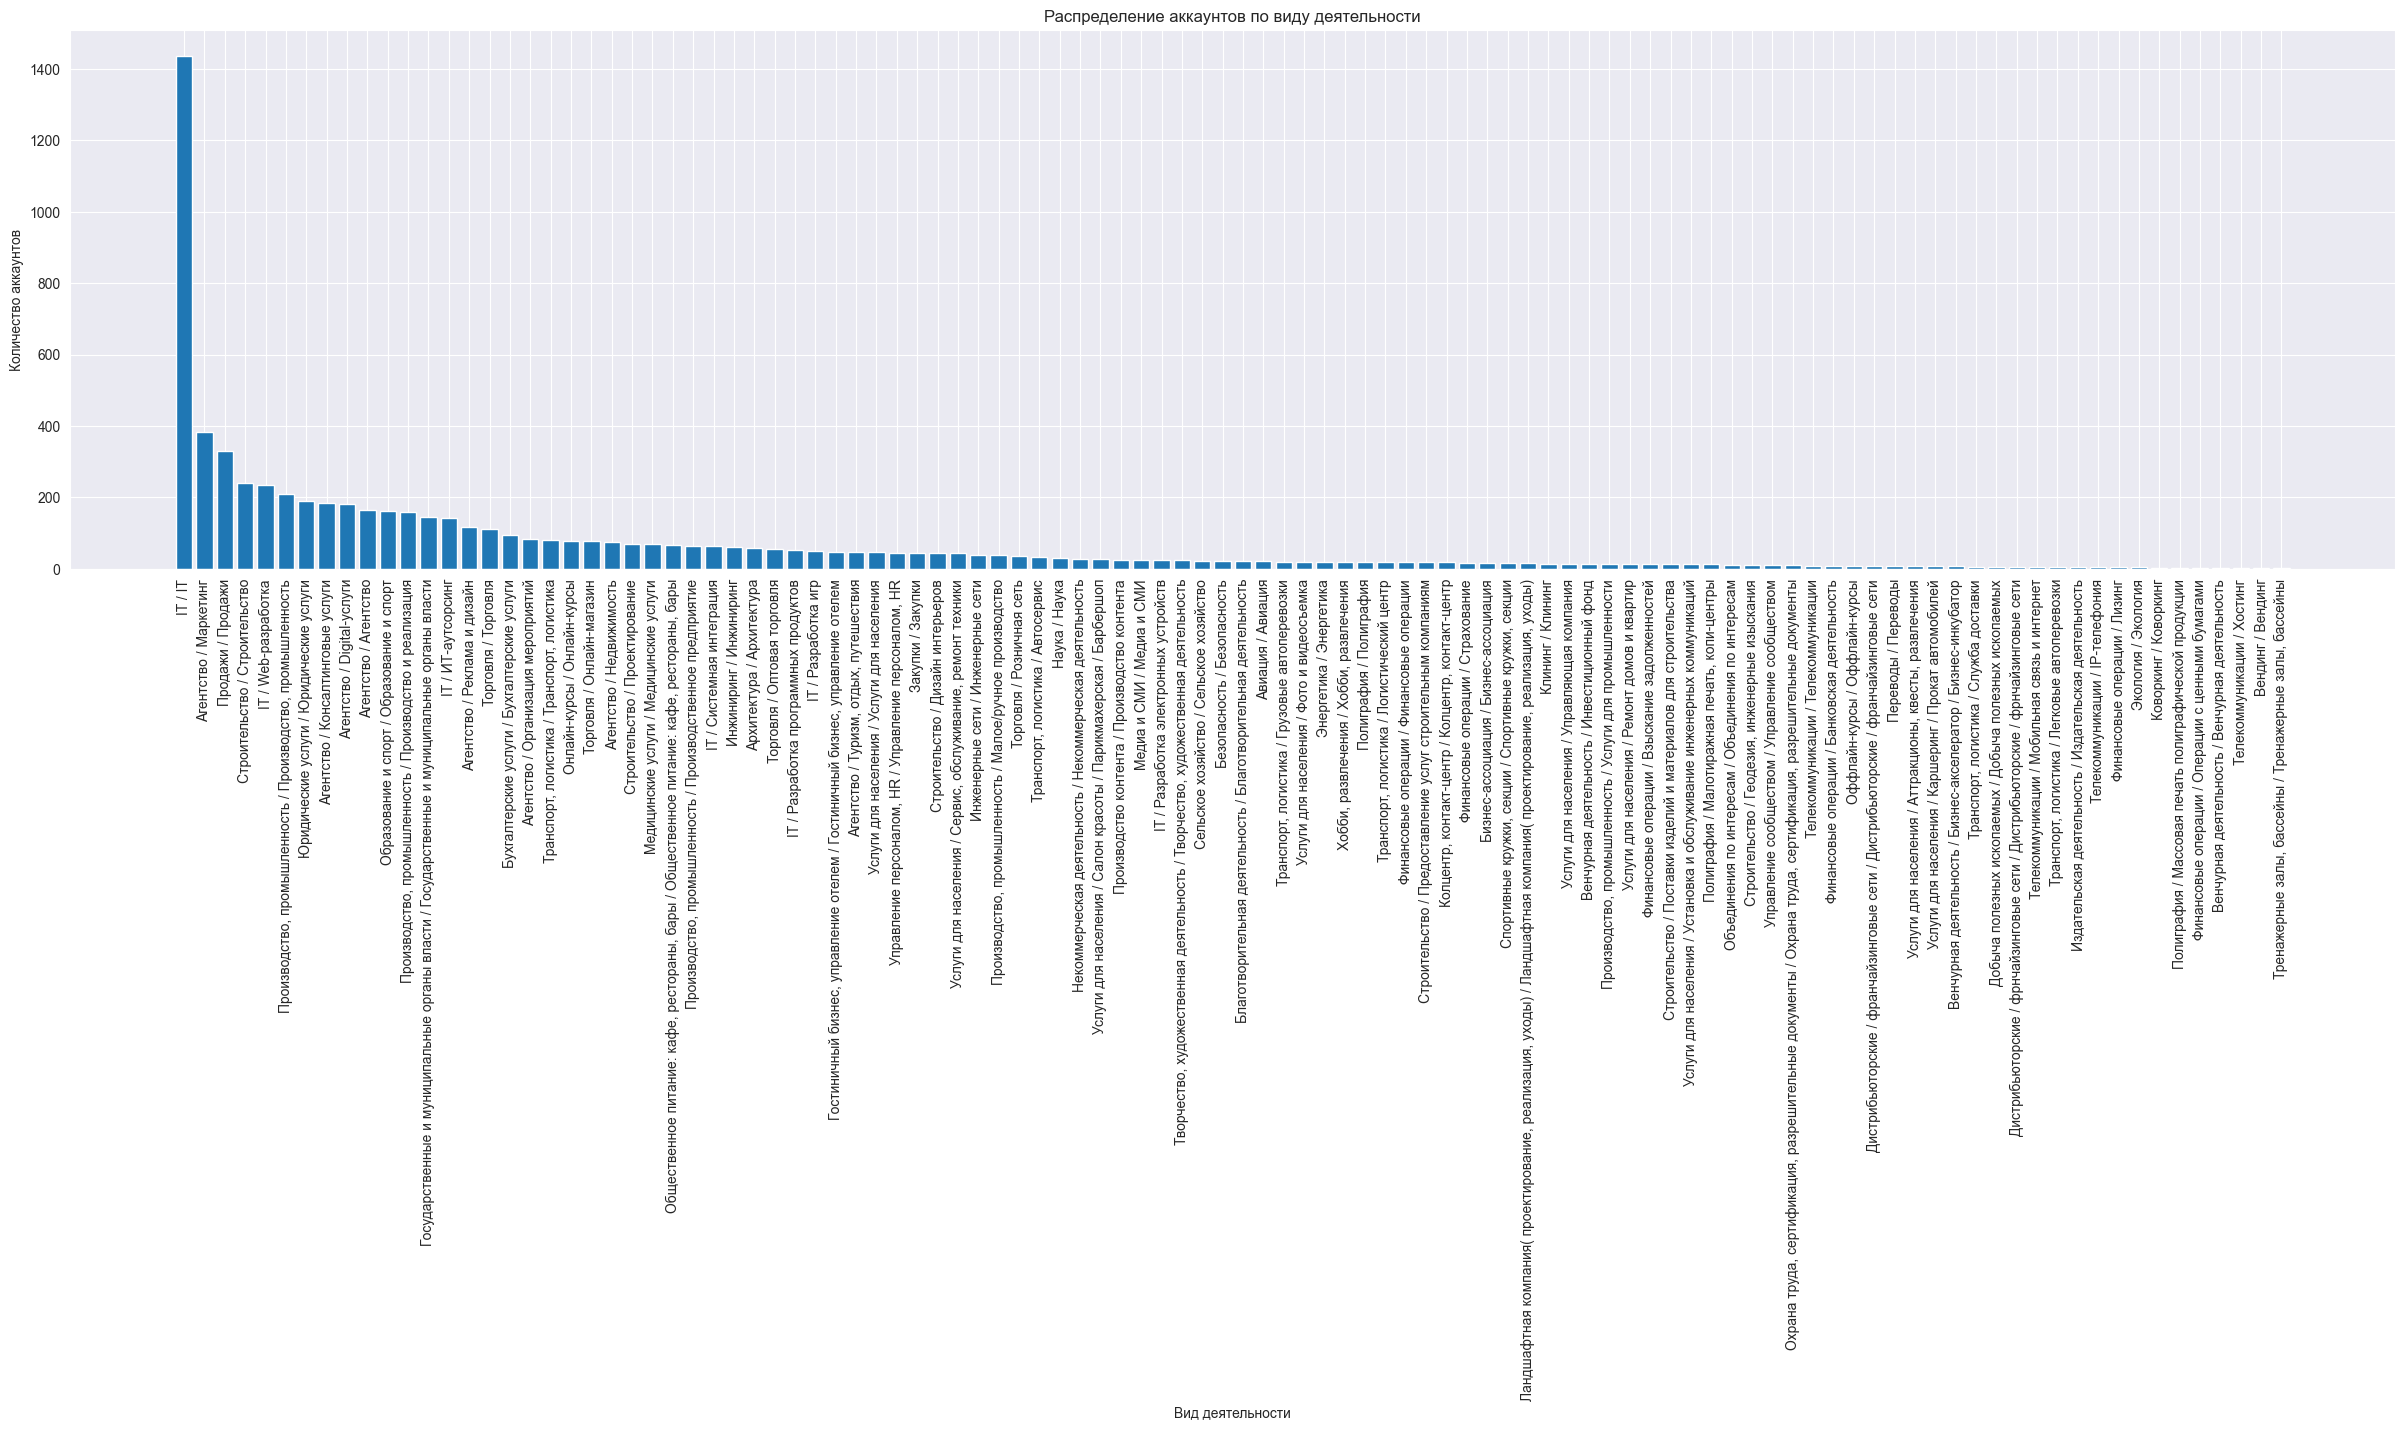

In [5]:
data.groupby('AccountOccupationText')['AccountID'].count()
pd.DataFrame([['Не указано', data.isna()['AccountOccupationText'].sum()]], columns=['AccountOccupationText', 'AccountID'])

grouped = data.groupby('AccountOccupationText').agg({
    'AccountID': 'count'
})
grouped = grouped.sort_values(['AccountID'], ascending=False)

plt.figure(figsize=(30, 7))

plt.bar(list(grouped.index), list(np.squeeze(grouped.values)))
plt.xticks(rotation=90)
plt.xlabel('Вид деятельности')
plt.ylabel('Количество аккаунтов')
plt.title('Распределение аккаунтов по виду деятельности')
plt.show()

### 3. Создайте новые столбцы, содержащие информацию об ответах на вопросы

In [6]:
data['Answers'] = data['Answers'].apply(json.loads)
data = pd.concat([data.drop(['Answers'], axis=1), data['Answers'].apply(pd.Series)], axis=1)

0                    Не хочу отвечать
1       Руководитель отдела / команды
2                    Владелец бизнеса
3                    Не хочу отвечать
4             Работает самостоятельно
                    ...              
7552          Директор / топ-менеджер
7553          Работает самостоятельно
7554                 Не хочу отвечать
7555                 Не хочу отвечать
7556    Руководитель отдела / команды
Name: whoAmI, Length: 7557, dtype: object

### 4. Создайте новые столбцы, содержащие данные об accountparams и accountregistration

In [7]:
json_columns = ['AccountParams', 'AccountRegistrationGAFullData', 'AccountRegistrationGAData']

for column in json_columns:
    data[column] = data[column].fillna('{}')
    data[column] = data[column].apply(json.loads)
    data = pd.concat([data.drop([column], axis=1), data[column].apply(pd.Series)], axis=1)

data = data.loc[:,~data.columns.duplicated()].copy()

### 5. Постройте графики показывающие долю пользователей с активным триалом

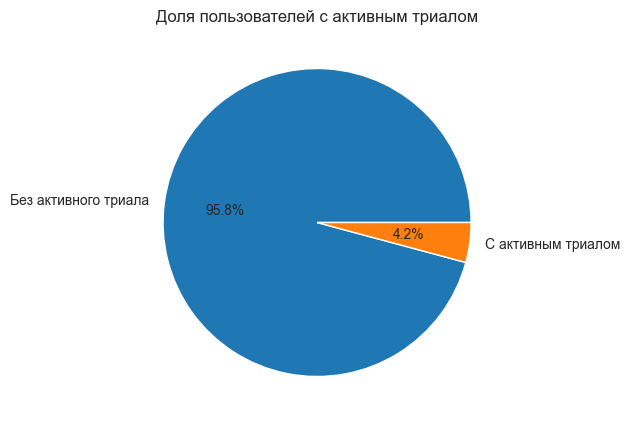

In [8]:
active_trial = data.groupby('AccountHasActiveLicense').agg({
    'AccountID': 'count'
})

plt.figure(figsize=(5, 5))
plt.title('Доля пользователей с активным триалом')
plt.pie(active_trial.values.flatten(), labels=['Без активного триала', 'С активным триалом'], autopct='%1.1f%%')
plt.show()

### 6. Постройте распределение метрик пользователей (графики + таблицы с квантилями) 

C:\Users\vm140\AppData\Local\Temp\ipykernel_7432\4274281688.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


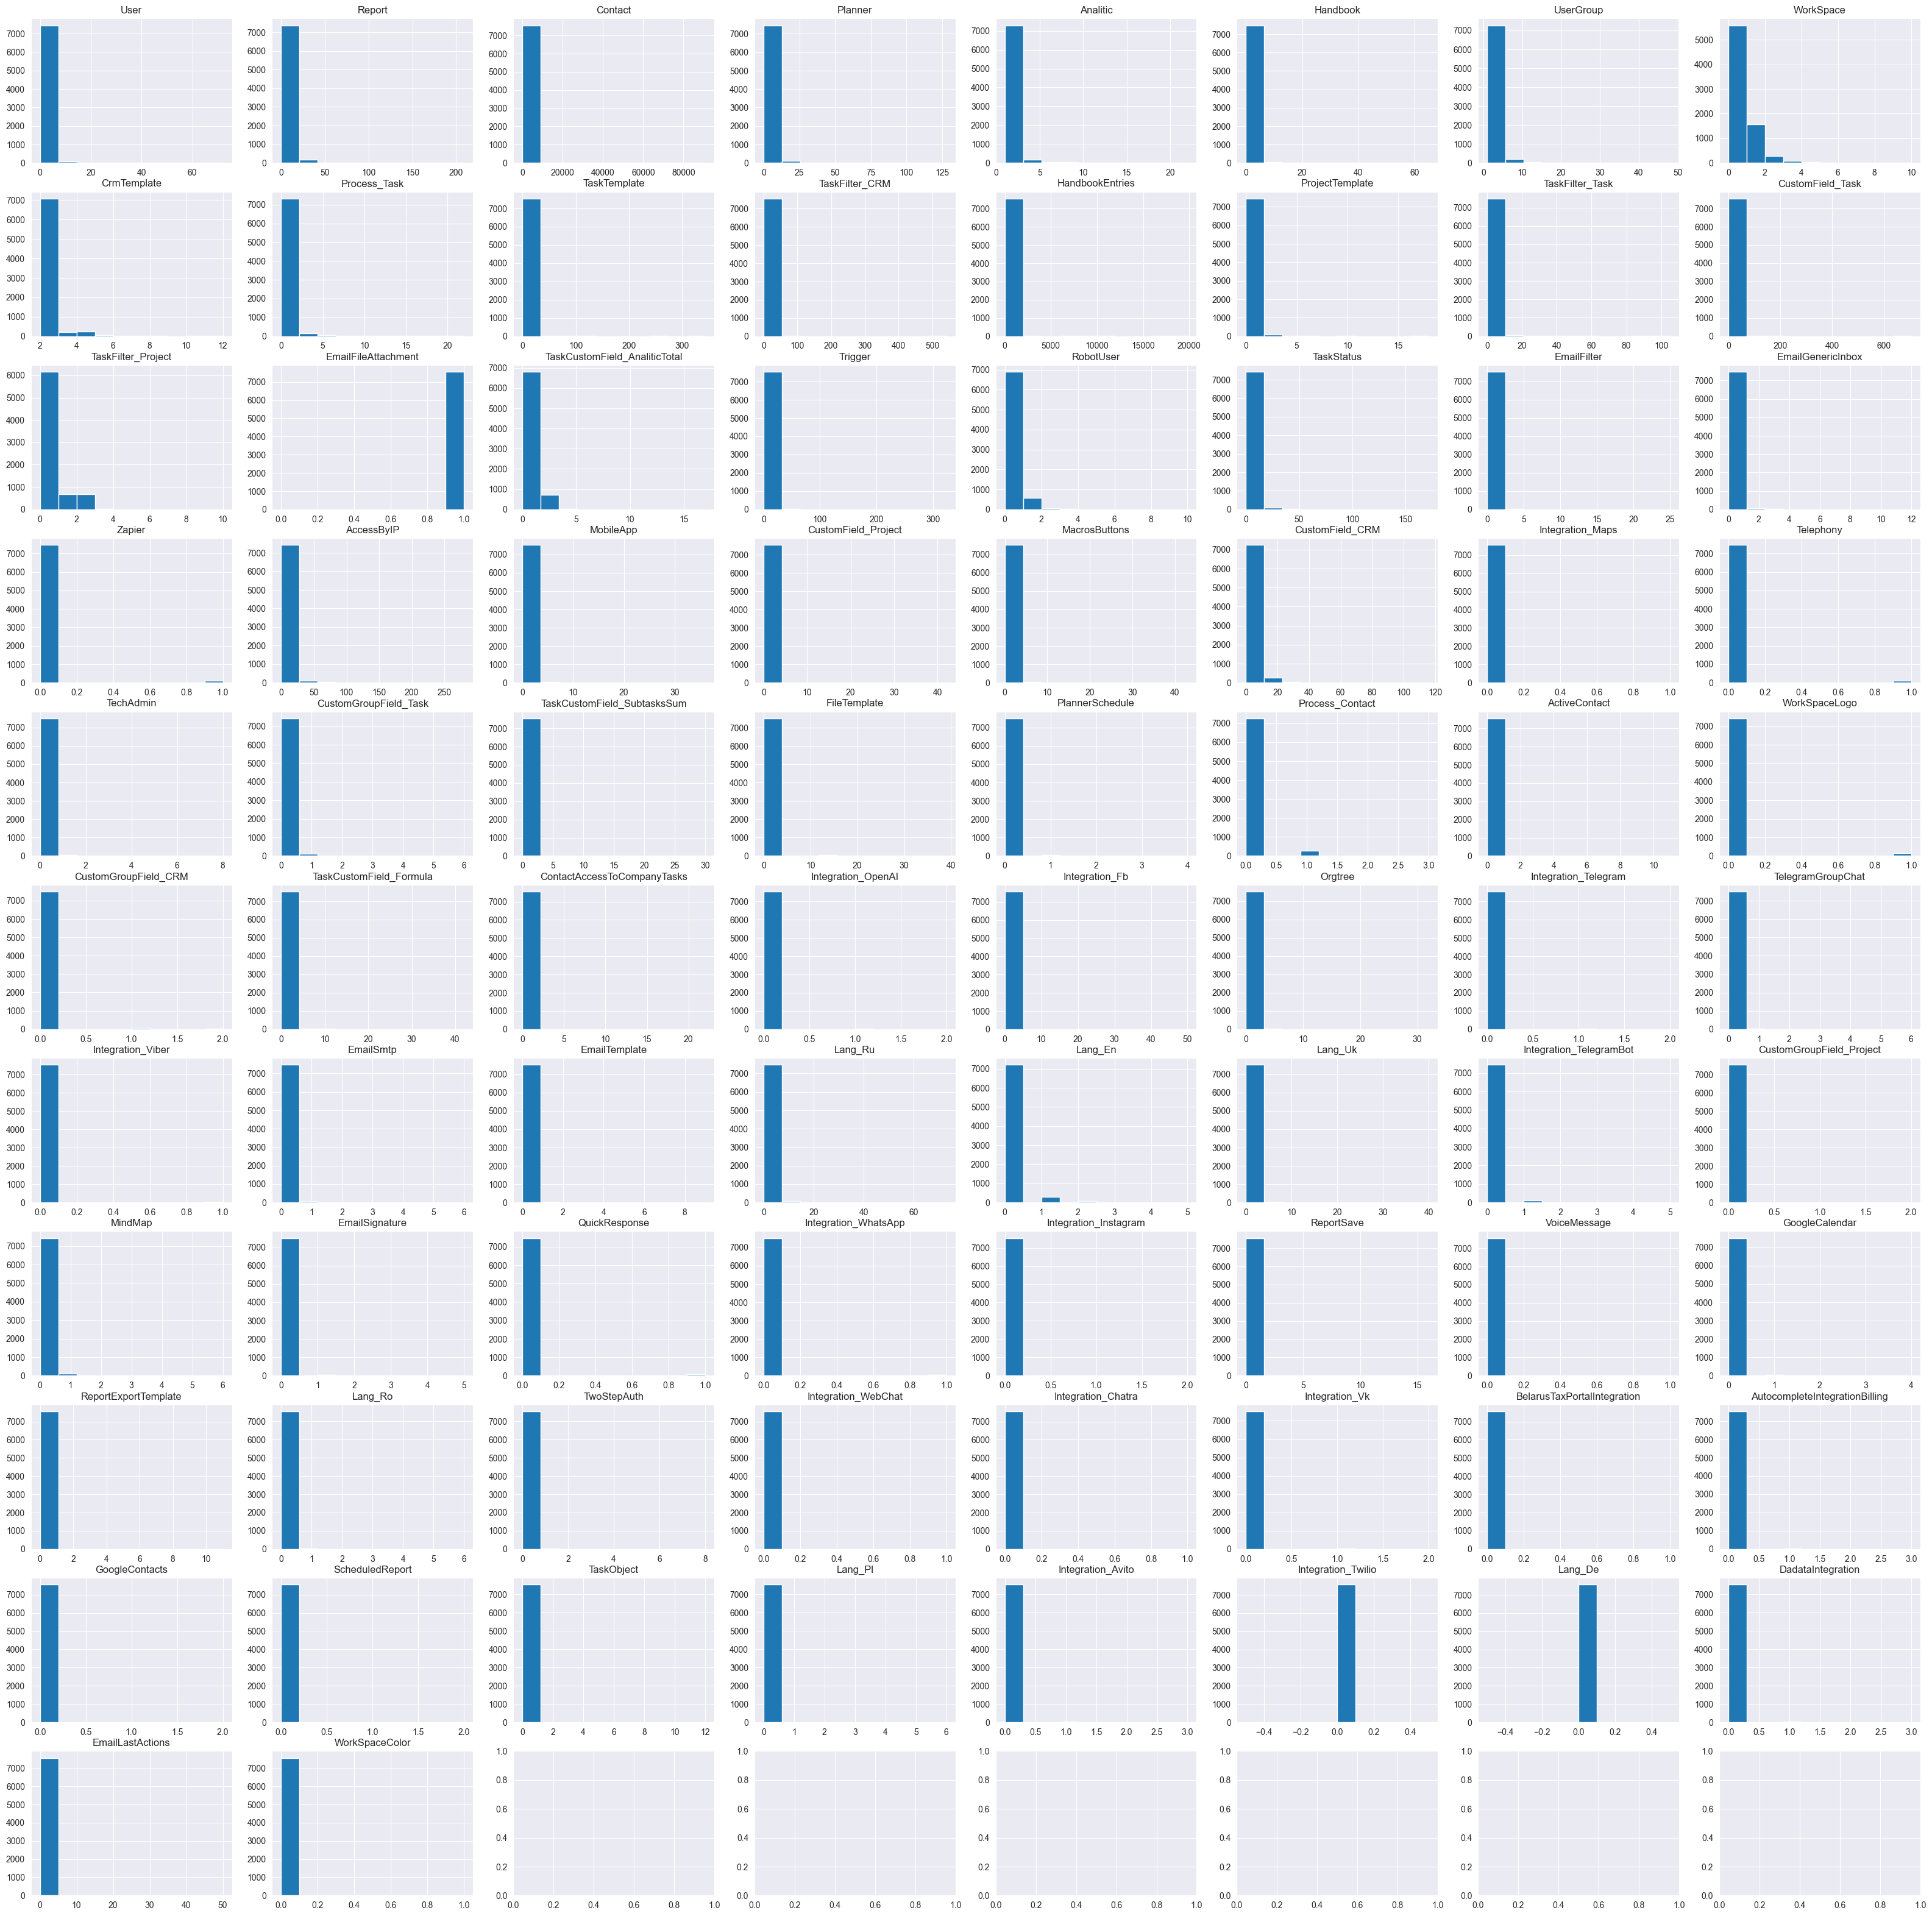

In [9]:
metrics_columns = list(metrics.columns)
metrics_columns.remove('AccountID')
metrics_columns.remove('Unnamed: 0')

fig, axes = plt.subplots(nrows=11, ncols=8, figsize=(40, 40))

for i in range(11):
    for j in range(8):
        if i*8+j < len(metrics_columns):
            axes[i, j].hist(data[metrics_columns[i*8+j]])
            axes[i, j].set_title(metrics_columns[i*8+j])
    
fig.show()

In [10]:
df_quantiles = pd.DataFrame(columns=['q1', 'q2', 'q3'], index=metrics_columns)

for metric in metrics_columns:
    q1, q2, q3 = np.quantile(data[metric], [0.25, 0.5, 0.75])
    df_quantiles.loc[metric, 'q1'] = q1
    df_quantiles.loc[metric, 'q2'] = q2
    df_quantiles.loc[metric, 'q3'] = q3

print(df_quantiles)

                      q1    q2    q3
User                 1.0   1.0   2.0
Report              11.0  11.0  13.0
Contact              1.0   1.0   1.0
Planner              4.0   4.0   6.0
Analitic             1.0   1.0   1.0
...                  ...   ...   ...
Integration_Twilio   0.0   0.0   0.0
Lang_De              0.0   0.0   0.0
DadataIntegration    0.0   0.0   0.0
EmailLastActions     0.0   0.0   0.0
WorkSpaceColor       0.0   0.0   0.0

[82 rows x 3 columns]


### 7. Постройте модели для оценки каждой из метрик, выведите важной признаков.

In [36]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

labelencoder = LabelEncoder()
model_data = data.copy()
model_data = model_data.drop('AccountID', axis=1)
columns = list(model_data.columns)
ar = []
for col in columns:
    if col[-2:] == 'ru' or col[-2:] == 'en' or col[-2:] == 'ua' or col[-2:] == 'uk' or col[-2:] == 'ro' or col[-2:] == 'pl':
        ar.append(col)
        
model_data = model_data.drop(ar, axis=1)

model_data = model_data.dropna(thresh=model_data.shape[0] * (1 - 0.7), axis=1)

columns = list(model_data.columns)

num = list(model_data.select_dtypes(include=np.number))

for el in num:
    columns.remove(el)

model_data = model_data.fillna(model_data[num].median())
model_data = model_data.fillna('empty')
model_data.count()

labelencoder = LabelEncoder()
for i in range (len(columns)):
    try:
        model_data[columns[i]] = model_data[columns[i]].astype(str)
        model_data[columns[i]] = labelencoder.fit_transform(model_data[columns[i]].values)
    except:
        print(columns[i] + str(i))

model_data.corr()

y = model_data['User']
X = model_data.drop(['User'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)


model = Lasso()

model.fit(X_train, y_train)

coef_las = zip(model_data.columns, model.coef_)

print("R-squared:", r2_score(y_test, model.predict(X_test)))
print("RMSE:", np.sqrt(mean_squared_error(y_test, model.predict(X_test))))
print("MAE:", mean_absolute_error(y_test,  model.predict(X_test)))
print()
model.predict(X_test) 

weights = zip(model_data.columns, model.coef_)
for i in weights:
    print(str(i[0]) + '\t' + str(round(i[1], 5)))

R-squared: 0.6594914409195811
RMSE: 1.4774697693669718
MAE: 0.5649096852627601

AccountOccupationID	0.0
AccountOccupationText	0.0
AccountSystemEmailsUnsubscribe	0.0
AccountConfCrmOnCreation	0.0
AccountHadPartner	0.0
AccountWorkspaceColorType	0.0
AccountIsLiveOn10Day	0.00039
AccountConfs10Day	0.00091
AccountConfsTrialEnd	0.00022
AccountHasActiveLicense	0.0
AccountBlockedTrialExpired	-0.0
User	0.0
Report	5e-05
Contact	0.0
Planner	0.0
Analitic	0.0
Handbook	0.15324
UserGroup	0.0
WorkSpace	0.0
CrmTemplate	0.0
Process_Task	0.0
TaskTemplate	0.0
TaskFilter_CRM	0.00054
HandbookEntries	0.0
ProjectTemplate	0.0
TaskFilter_Task	0.0
CustomField_Task	0.0
TaskFilter_Project	-0.0
EmailFileAttachment	0.0
TaskCustomField_AnaliticTotal	0.0
Trigger	0.0
RobotUser	0.0
TaskStatus	0.0
EmailFilter	0.0
EmailGenericInbox	-0.0
Zapier	-0.0
AccessByIP	0.0
MobileApp	0.0
CustomField_Project	0.0
MacrosButtons	0.0
CustomField_CRM	0.0
Integration_Maps	0.0
Telephony	0.0
TechAdmin	0.0
CustomGroupField_Task	0.0
TaskCustomFi